In [18]:
!pip install tqdm
!pip install torchtext==0.6.0
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [19]:
import torch
import torchtext
import spacy
from torchtext.data import get_tokenizer
from torch.utils.data import random_split
from torchtext.experimental.datasets import IMDB
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [20]:
class MySelfAttention(nn.Module):
    """
    Self attention layer
    """
    def __init__(self, input_dim):
        """
        :param input_dim: The feature dimension the input tokens (d).
        """
        super(MySelfAttention, self).__init__()
        self.input_dim = input_dim

        ### YOUR CODE HERE ###
        # Initialize the query, key and value weights
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

        self.root_input_dim = input_dim ** 0.5

    def forward(self, x):
        ### YOUR CODE HERE ###
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Transpose inner dimensions for attention scores calculation by forumla
        attention_scores = torch.bmm(Q, K.transpose(1, 2)) / self.root_input_dim
        # Normalize the scores based on the innermost dimension (the dimension of the resulting scores)
        normalized_scores = F.softmax(attention_scores, dim=-1)
        # Calculate self attention with relation to V(values)
        self_attention = torch.bmm(normalized_scores, V)
        return self_attention


class MyLayerNorm(nn.Module):
    """
    Layer Normalization layer.
    """
    def __init__(self, input_dim):
        """
        :param input_dim: The dimension of the input (T, d).
        """
        super(MyLayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(*input_dim))
        self.beta = nn.Parameter(torch.zeros(*input_dim))
        self.epsilon = 1e-8

    def forward(self, x):
        ### YOUR CODE HERE ###
        # Calculates the mean over T*d elements, in inner 2 dimensions
        mew = x.mean(dim=(-1,-2), keepdim=True)
        # Calculates the variance
        sigma = (x - mew).pow(2).mean(dim=(-1,-2), keepdim=True)
        # Returns the normalized features
        return self.gamma * (x - mew) / torch.sqrt(sigma + self.epsilon) + self.beta

class MyTransformerBlock(nn.Module):
    """
    Transformer block.
    """
    def __init__(self, max_len, input_dim):
        super(MyTransformerBlock, self).__init__()
        self.attention = MySelfAttention(input_dim)
        self.norm1 = MyLayerNorm((max_len, input_dim))
        self.norm2 = MyLayerNorm((max_len, input_dim))
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.attention(x)
        x = self.norm1(self.dropout(out) + x)
        out = self.fc2(F.relu(self.fc1(x)))
        out = self.norm2(out + x)
        return out

class MyTransformer(nn.Module):
    """
    Transformer.
    """
    def __init__(self, vocab, max_len, num_of_blocks):
        """
        :param vocab: The vocabulary object.
        :param num_of_blocks: The number of transformer blocks.
        """
        super(MyTransformer, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.emb_dim = self.embedding.embedding_dim
        self.max_len = max_len
        self.blocks = nn.ModuleList([MyTransformerBlock(self.max_len, self.emb_dim) for _ in range(num_of_blocks)])
        self.fc = nn.Linear(self.emb_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        for block in self.blocks:
            x = block(x)
        avg_pooling = x.mean(dim=1)
        x = self.fc(avg_pooling)
        return x





In [21]:
def pad_trim(data):
    ''' Pads or trims the batch of input data.

    Arguments:
        data (torch.Tensor): input batch
    Returns:
        new_input (torch.Tensor): padded/trimmed input
        labels (torch.Tensor): batch of output target labels
    '''
    data = list(zip(*data))
    # Extract target output labels
    labels = torch.tensor(data[0]).float().to(device)
    # Extract input data
    inputs = data[1]

    # Extract only the part of the input up to the MAX_SEQ_LEN point
    # if input sample contains more than MAX_SEQ_LEN. If not then
    # select entire sample and append <pad_id> until the length of the
    # sequence is MAX_SEQ_LEN
    new_input = torch.stack([torch.cat((input[:MAX_SEQ_LEN],
                                        torch.tensor([pad_id] * max(0, MAX_SEQ_LEN - len(input))).long()))
                             for input in inputs])

    return new_input, labels

def split_train_val(train_set):
    ''' Splits the given set into train and validation sets WRT split ratio
    Arguments:
        train_set: set to split
    Returns:
        train_set: train dataset
        valid_set: validation dataset
    '''
    train_num = int(SPLIT_RATIO * len(train_set))
    valid_num = len(train_set) - train_num
    generator = torch.Generator().manual_seed(SEED)
    train_set, valid_set = random_split(train_set, lengths=[train_num, valid_num],
                                        generator=generator)
    return train_set, valid_set

def load_imdb_data(batch_size=32):
    """
    This function loads the IMDB dataset and creates train, validation and test sets.
    It should take around 15-20 minutes to run on the first time (it downloads the GloVe embeddings, IMDB dataset and extracts the vocab).
    Don't worry, it will be fast on the next runs. It is recommended to run this function before you start implementing the training logic.
    :return: train_set, valid_set, test_set, train_loader, valid_loader, test_loader, vocab, pad_id
    """
    cwd = os.getcwd()
    if not os.path.exists(cwd + '/.vector_cache'):
        os.makedirs(cwd + '/.vector_cache')
    if not os.path.exists(cwd + '/.data'):
        os.makedirs(cwd + '/.data')
    # Extract the initial vocab from the IMDB dataset
    vocab = IMDB(data_select='train')[0].get_vocab()
    # Create GloVe embeddings based on original vocab word frequencies
    glove_vocab = torchtext.vocab.Vocab(counter=vocab.freqs,
                                        max_size=MAX_VOCAB_SIZE,
                                        min_freq=MIN_FREQ,
                                        vectors=torchtext.vocab.GloVe(name='6B'))
    # Acquire 'Spacy' tokenizer for the vocab words
    tokenizer = get_tokenizer('spacy', 'en_core_web_sm')
    # Acquire train and test IMDB sets with previously created GloVe vocab and 'Spacy' tokenizer
    train_set, test_set = IMDB(tokenizer=tokenizer, vocab=glove_vocab)
    vocab = train_set.get_vocab()  # Extract the vocab of the acquired train set
    pad_id = vocab['<pad>']  # Extract the token used for padding

    train_set, valid_set = split_train_val(train_set)  # Split the train set into train and validation sets

    train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=pad_trim)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, collate_fn=pad_trim)
    test_loader = DataLoader(test_set, batch_size=batch_size, collate_fn=pad_trim)
    return train_set, valid_set, test_set, train_loader, valid_loader, test_loader, vocab, pad_id

In [22]:
def train_and_eval_model(model, device, criterion, optimizer, train_loader, valid_loader, test_loader, num_of_epochs=5):
    model_loss = {'Train': [], 'Valid': []}
    for epoch in range(num_of_epochs):
        # Train Model
        train_loss_values = []
        model.train()
        for batch in tqdm(train_loader, desc='Train', total=len(train_loader)):
            inputs_embeddings, labels = batch
            inputs_embeddings, labels = inputs_embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs_embeddings.squeeze())
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss_values.append(loss.item())

        epoch_train_loss = np.mean(train_loss_values)

        # Eval on validation set
        valid_loss_values = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_loader, desc='Valid', total=len(valid_loader)):
                inputs_embeddings, labels = batch
                inputs_embeddings, labels = inputs_embeddings.to(device), labels.to(device)
                outputs = model(inputs_embeddings.squeeze())
                loss = criterion(outputs.squeeze(), labels)
                valid_loss_values.append(loss.item())

        epoch_valid_loss = np.mean(valid_loss_values)
        print(f'Epoch {epoch + 1}/{num_of_epochs}, Train Loss: {epoch_train_loss:.6f}, Valid Loss: {epoch_valid_loss:.6f}')
        model_loss['Train'].append(epoch_train_loss)
        model_loss['Valid'].append(epoch_valid_loss)


    # Plot train and valid loss
    plt.plot(model_loss['Train'], label='Train', marker='o')
    plt.plot(model_loss['Valid'], label='Valid', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model, model_loss

def compute_test_accuracy(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        correct_preds = 0.
        for batch in tqdm(test_loader, desc='Test', total=len(test_loader)):
            inputs_embeddings, labels = batch
            inputs_embeddings, labels = inputs_embeddings.to(device), labels.to(device)
            outputs = model(inputs_embeddings.squeeze())
            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            correct_preds += (predicted == labels).sum().item()
        eval_accuracy = correct_preds / len(test_loader.dataset)
        print("Test accuracy:", eval_accuracy)
    return eval_accuracy

25000lines [00:10, 2462.95lines/s]
Valid: 100%|██████████| 157/157 [00:01<00:00, 81.69it/s]


Epoch 1/5, Train Loss: 0.482955, Valid Loss: 0.386583


Valid: 100%|██████████| 157/157 [00:02<00:00, 73.00it/s]


Epoch 2/5, Train Loss: 0.359801, Valid Loss: 0.368043


Valid: 100%|██████████| 157/157 [00:01<00:00, 78.92it/s]


Epoch 3/5, Train Loss: 0.342035, Valid Loss: 0.357704


Valid: 100%|██████████| 157/157 [00:01<00:00, 78.73it/s]


Epoch 4/5, Train Loss: 0.332333, Valid Loss: 0.352118


Valid: 100%|██████████| 157/157 [00:02<00:00, 77.54it/s]


Epoch 5/5, Train Loss: 0.325601, Valid Loss: 0.348401


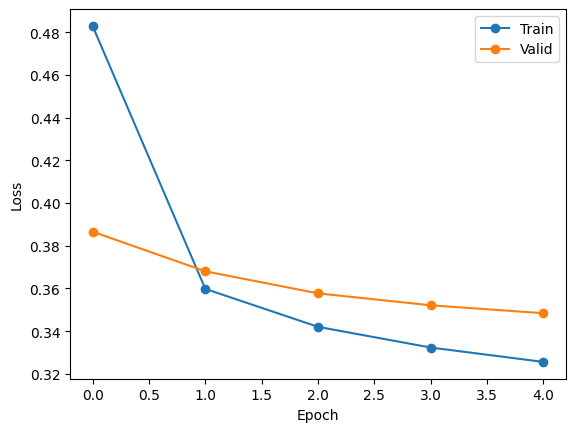

Test: 100%|██████████| 782/782 [00:10<00:00, 76.13it/s]

Test accuracy: 0.85236


In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_VOCAB_SIZE = 25000 # Maximum number of words in the vocabulary
MIN_FREQ = 10 # We include only words which occur in the corpus with some minimal frequency
MAX_SEQ_LEN = 500 # We trim/pad each sentence to this number of words
SPLIT_RATIO = 0.8 # Split ratio between train and validation set
SEED = 0

# HYPERPARAMETERS
batch_size = 32
num_of_blocks = 1
num_of_epochs = 5
learning_rate = 0.0001

# Load the IMDB dataset
train_set, valid_set, test_set, train_loader, valid_loader, test_loader, vocab, pad_id = load_imdb_data()

model = MyTransformer(vocab=vocab, max_len=MAX_SEQ_LEN, num_of_blocks=num_of_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()
# Complete Sentiment Analysis model training and evaluation
model, losses = train_and_eval_model(model, device, criterion, optimizer, train_loader, valid_loader, test_loader, num_of_epochs=num_of_epochs)
test_acc = compute_test_accuracy(model, test_loader, device)

